In [106]:
from keras.layers import Dropout,Dense
from keras.models import Sequential

from sklearn.utils import shuffle
from tensorflow import *
from scipy import stats

# import tensorflow_decision_forests 

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

from scipy.stats import uniform, randint

import matplotlib.pyplot as plt
import scikitplot as skplt
import tensorflow as tf
import xgboost as xgb
import pandas as pd
import numpy as np

import os

%matplotlib inline

In [2]:
df_test = pd.read_table("TST.cod")
df_tr = pd.read_table("TRNcod.xls") ##! <<<<<<<<<<<< READ_EXCEL NÃO FUNCIONA

In [81]:
loss_function = keras.losses.SparseCategoricalCrossentropy()

patienceCallback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 20)

def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

def createMLPModel(layers=[Dense(64, activation = 'relu'),
                           Dense(32, activation = 'sigmoid'),
                           Dense(10, activation = 'sigmoid'),
                           Dense(2, activation = 'sigmoid'),],
                   file_path='./training_default',
                   loss=loss_function,
                   metrics=['accuracy'],
                   optimizer='nadam'
                   ):
  """Returns an MLP model based on params

  Args:
      layers (list, optional): list of layers. Defaults to [Dense(64, activation = 'relu'), Dense(32, activation = 'sigmoid'), Dense(10, activation = 'sigmoid'), Dense(2, activation = 'sigmoid'),].
      file_path (str, optional): path to save the weights. Defaults to './training_default'.
      loss (loss function, optional): loss function used by the model. Defaults to loss_function.
      metrics (list, optional): list of metrics to return on verbose. Defaults to ['accuracy'].
  """
  new_model = Sequential(layers=layers)


  cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)
  
  new_model.compile(optimizer = optimizer,
      loss = loss,
      metrics=metrics)
  
  return new_model


## Tratamento dos dados

In [4]:
if "IND_BOM_1_1" in df_tr:
    df_tr = df_tr.drop(columns = ["IND_BOM_1_1"])
if "INDEX" in df_tr:
    df_tr = df_tr.drop(columns = ["INDEX"])
if "IND_BOM_1_2" in df_tr:
    df_tr = df_tr.rename(columns = {"IND_BOM_1_2": "CLASSE_INDIV"})

#0 = Classe 1
#1 = Classe 2

In [5]:
df_tr_class_1 = df_tr[df_tr['CLASSE_INDIV'] == 0]
df_tr_class_2 = df_tr[df_tr['CLASSE_INDIV'] == 1]

df_tr_class_1_a = df_tr_class_1.sample(frac = 0.66)
df_tr_class_1_b = df_tr_class_1.drop(df_tr_class_1_a.index)

df_tr_class_2_a = df_tr_class_2.sample(frac = 0.66)
df_tr_class_2_b = df_tr_class_2.drop(df_tr_class_2_a.index)

df_tr_class_2_a = pd.concat([df_tr_class_2_a,
                     df_tr_class_2_a.sample(len(df_tr_class_1_a) - len(df_tr_class_2_a))],
                     ignore_index = True,
                     sort = False)

df_tr_class_2_b = pd.concat([df_tr_class_2_b,
                     df_tr_class_2_b.sample(len(df_tr_class_1_b) - len(df_tr_class_2_b))],
                     ignore_index = True,
                     sort = False)

df_trein = pd.concat([df_tr_class_1_a, df_tr_class_2_a])
df_valid = pd.concat([df_tr_class_1_b, df_tr_class_2_b])

df_tr_class_1 = None
df_tr_class_2 = None

df_tr_class_1_a = None
df_tr_class_1_b = None
df_tr_class_2_a = None
df_tr_class_2_b = None

df_trein = shuffle(df_trein).reset_index().drop(columns = ["index"])
df_valid = shuffle(df_valid).reset_index().drop(columns = ["index"])

Dados de treinamento e validação

In [6]:
df_treinX = df_trein.drop(columns = ["CLASSE_INDIV"])
df_treinY = df_trein["CLASSE_INDIV"]
df_validX = df_valid.drop(columns = ["CLASSE_INDIV"])
df_validY = df_valid["CLASSE_INDIV"]

Dados de teste

In [7]:
if "IND_BOM_1_1" in df_test:
    df_test = df_test.drop(columns = ["IND_BOM_1_1"])
if "INDEX" in df_test:
    df_test = df_test.drop(columns = ["INDEX"])
if "IND_BOM_1_2" in df_test:
    df_test = df_test.rename(columns = {"IND_BOM_1_2": "CLASSE_INDIV"})


df_test_x = df_test.drop(columns = ["CLASSE_INDIV"])
df_test_y = df_test["CLASSE_INDIV"]


In [ ]:
MLPmodel = Sequential([
    Dense(246, activation = 'relu'),
    Dense(10, activation = 'sigmoid'),
    ])

tf.keras.optimizers.Adam(
    learning_rate=0.01
)

loss_function = keras.losses.SparseCategoricalCrossentropy()

MLPmodel.compile(optimizer = 'adam',
      loss = loss_function,
      metrics=['accuracy'],
      )

file_path = 'training_2/cp.ckpt'
file_dir = os.path.dirname(file_path)

cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)

MLPmodel.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 2000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY),
          verbose=2,

          )



### Acurácia muito baixa, precisamos passar pelo processo de tunagem

In [9]:
MLPmodel_2 = Sequential([
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'sigmoid'),
    Dense(10, activation = 'sigmoid'),
    Dense(10, activation = 'sigmoid'),
    ])

loss_function = keras.losses.SparseCategoricalCrossentropy()


file_path = 'training_3/cp.ckpt'
file_dir = os.path.dirname(file_path)


cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)

MLPmodel_2.compile(optimizer = 'nadam',
      loss = loss_function,
      metrics=['accuracy'])



MLPmodel_2.fit(df_treinX, df_treinY, epochs = 1, 
          batch_size = 2000, callbacks = [patienceCallback],  
          validation_data = (df_validX, df_validY),
          verbose=2,
          )

169/169 - 2s - loss: 0.7983 - accuracy: 0.5813 - val_loss: 0.6627 - val_accuracy: 0.6212 - 2s/epoch - 15ms/step


In [10]:
MLPmodel_2.load_weights(file_path) ## carregar os pesos do treinamento anterior

In [11]:
loss, acc = MLPmodel_2.evaluate(df_test_x, df_test_y, verbose=2)

4055/4055 - 3s - loss: 1.4691 - accuracy: 0.5992 - 3s/epoch - 660us/step


In [13]:
predictions = MLPmodel_2.predict(df_test_x)
test_results = predictions.argmax(axis=-1)
test_y = df_test_y.to_list()
stats.ks_2samp(test_y, test_results)

In [ ]:
MLPmodel_4 = Sequential([
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'sigmoid'),
    Dense(10, activation = 'sigmoid'),
    Dense(2, activation = 'sigmoid'),
    ])

file_path = 'training_4/cp.ckpt'
file_dir = os.path.dirname(file_path)

loss_function = keras.losses.SparseCategoricalCrossentropy()

cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)


MLPmodel_4.compile(optimizer = 'nadam',
      loss = loss_function,
      metrics=['accuracy'])

MLPmodel_4.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 1000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY))

In [ ]:
tf.keras.optimizers.Nadam(
    learning_rate=0.02
)

MLPmodel_5 = createMLPModel(layers=[Dense(64,activation="softmax"),
                             Dense(32, activation="softmax"),
                             Dense(16, activation='relu'),
                             Dense(2, activation='sigmoid')],
                             optimizer='adam',
                             loss=loss_function,
                             file_path='./training_dropout',
                             )

MLPmodel_5.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 1000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY),
          verbose=2)

In [ ]:
MLPmodel_6 = createMLPModel(layers=[
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'sigmoid'),
    Dense(10, activation = 'sigmoid'),
    Dense(2, activation = 'sigmoid'),
    ],
    file_path='training_6/cp.ckpt'
    )


MLPmodel_6.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 2000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY),
          verbose=2,
          )

In [ ]:
MLPmodel_7 = createMLPModel(layers=[
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'sigmoid'),
    Dense(64, activation = 'sigmoid'),
    Dense(2, activation = 'sigmoid'),
    ],
    file_path='training_7/cp.ckpt'
    )


MLPmodel_7.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 2000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY),
          verbose=2,
          )

In [ ]:
# predictions = MLPmodel_7.predict(df_test_x)
# test_results = predictions.argmax(axis=-1)
# test_y = df_test_y.to_list()
# stats.ks_2samp(test_y, test_results)

In [ ]:
MLPmodel_8 = createMLPModel(layers=[
    Dense(256, activation = 'relu'),
    Dropout(rate=0.15),
    Dense(128, activation = 'sigmoid'),
    Dropout(rate=0.1),
    Dense(64, activation = 'sigmoid'),
    Dropout(rate=0.1),
    Dense(2, activation = 'sigmoid'),
    ],
    )

file_path='./training_8/cp.ckpt'
cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)


history = MLPmodel_8.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 2000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY),
          verbose=2,
          )

In [48]:
MLPmodel_9 = createMLPModel(layers=[
    Dense(256, activation = 'relu'),
    Dropout(rate=0.15),
    Dense(128, activation = 'relu'),
    Dropout(rate=0.1),
    Dense(64, activation = 'sigmoid'),
    Dropout(rate=0.1),
    Dense(2, activation = 'sigmoid'),
    ],
    )

file_path='./training_9/cp.ckpt'

cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)

history = MLPmodel_9.fit(df_treinX, df_treinY, epochs = 1, 
          batch_size = 2000, callbacks = [patienceCallback],  
          validation_data = (df_validX, df_validY),
          verbose=2,
          )

169/169 - 5s - loss: 0.6674 - accuracy: 0.5962 - val_loss: 0.6433 - val_accuracy: 0.6287 - 5s/epoch - 28ms/step


In [49]:
MLPmodel_9.load_weights(file_path)

4055/4055 [==============================] - 3s 711us/step
Matriz de confusão no conjunto de teste:
array([[55378, 29655],
       [20592, 24108]], dtype=int64)
array([[0.08919156, 0.89489263, 0.91080844, 0.10510736],
       [0.2637673 , 0.6724466 , 0.7362327 , 0.32755342],
       [0.51969635, 0.19188994, 0.48030362, 0.80811006],
       ...,
       [0.3151877 , 0.63762075, 0.6848123 , 0.36237925],
       [0.46305925, 0.47535145, 0.53694075, 0.52464855],
       [0.08125359, 0.8276527 , 0.9187464 , 0.17234734]], dtype=float32)

Performance no conjunto de teste:
0.6126891384613012 0.5393288590604027 0.44841247698231124 0.48968648121629443


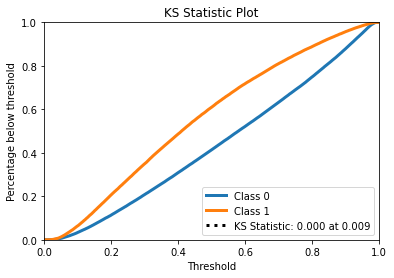


Accuracy:         0.6127
Recall:           0.5393
Precision:        0.4484
F1:               0.4897
AUROC:            0.3670
AUPR:             0.2681


In [52]:
y_pred_scores = MLPmodel_9.predict(df_test_x)
y_pred_class = y_pred_scores.argmax(axis=-1)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(df_test_y, y_pred_class))

print(y_pred_scores)


print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(df_test_y.to_list(), y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [34]:
df_test_y.size, len(y_pred_class), len(y_pred_scores)

(129733, 129733, 129733)

In [ ]:
RFmodel = tfdf.keras.RandomForestModel()

RFmodel.fit(tfdf.keras.pd_dataframe_to_tf_dataset(df_trein, label = "CLASSE_INDIV"), 
          callbacks = [patienceCallback])

In [ ]:
RFmodel.summary()

In [ ]:
RFmodel.compile(metrics = ["accuracy"])
RFmodel.evaluate(tfdf.keras.pd_dataframe_to_tf_dataset(df_valid, label = "CLASSE_INDIV"))

In [16]:
tfdf.model_plotter.plot_model_in_colab(RFmodel, tree_idx=0, max_depth = 3)

### Gradient Boosting

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, r2_score, matthews_corrcoef 

from numpy import round


In [9]:
# gb_model = GradientBoostingRegressor(n_estimators=500, max_depth=5, random_state=42, verbose=1) # 1st try
# gb_model_2 = GradientBoostingRegressor(n_estimators=248, max_depth=5, random_state=42, verbose=1, )
gb_model_3 = GradientBoostingRegressor(n_estimators=200, max_depth=10, random_state=42, verbose=1, learning_rate=0.01)


In [10]:
gb_model_3.fit(df_treinX, df_treinY)

      Iter       Train Loss   Remaining Time 
         1           0.2493          114.90m
         2           0.2486          117.09m
         3           0.2478          117.29m
         4           0.2472          116.49m
         5           0.2465          115.87m
         6           0.2458          115.36m
         7           0.2451          114.39m
         8           0.2445          113.73m
         9           0.2439          112.84m
        10           0.2432          111.96m
        20           0.2374          105.84m
        30           0.2324           99.24m
        40           0.2280           92.57m
        50           0.2241           86.59m
        60           0.2206           80.77m
        70           0.2174           75.23m
        80           0.2146           69.75m
        90           0.2121           64.53m
       100           0.2098           59.07m
       200           0.1929            0.00s


GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=200,
                          random_state=42, verbose=1)

In [11]:
y_pred = round(gb_model_3.predict(df_test_x))

In [12]:
accuracy = accuracy_score(df_test_y.to_list(), y_pred)

In [17]:
accuracy

0.6474913861546406

In [83]:
import pickle

with open('./gradient_boosting/model3.pkl', 'wb') as file:
    pickle.dump(gb_model_3, file)

In [15]:
with open('./gradient_boosting/model3.pkl', 'rb') as file:
    model = pickle.load(file)

In [16]:
round(model.predict(df_test_x))

array([0., 0., 1., ..., 0., 1., 0.])

Matriz de confusão no conjunto de teste:
array([[53784, 31249],
       [14483, 30217]], dtype=int64)

Performance no conjunto de teste:


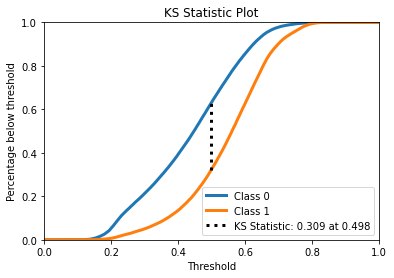


Accuracy:         0.6475
Recall:           0.6760
Precision:        0.4916
F1:               0.5692
AUROC:            0.7107
AUPR:             0.5485


In [82]:
current_model = gb_model_3

y_pred_scores = current_model.predict(df_test_x)

y_pred_class = round(y_pred_scores).tolist()

y_pred_scores_0 = 1 - y_pred_scores
# y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=-1)
y_pred_scores = np.column_stack((y_pred_scores_0,y_pred_scores))

# skplt.metrics.plot_ks_statistic(y_true=df_test_y.to_list(), y_probas=y_pred_scores)
# plt.show()

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(df_test_y, y_pred_class))

print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(df_test_y.to_list(), y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## XGBoost

In [105]:
x = df_treinX
y = df_treinY

In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric="auc", early_stopping_rounds=10)
xgb_model.fit(x,y, verbose=1, eval_set=[(df_validX, df_validY)])

In [102]:
y_pred = xgb_model.predict_proba(df_test_x)
y_pred_class = xgb_model.predict(df_test_x)
y_pred

array([[0.84529066, 0.15470931],
       [0.85320103, 0.14679897],
       [0.36480427, 0.63519573],
       ...,
       [0.85255915, 0.14744087],
       [0.35119438, 0.6488056 ],
       [0.77593946, 0.22406054]], dtype=float32)

best score: 0.7120153367224351, best iteration: 35, best ntree limit 36


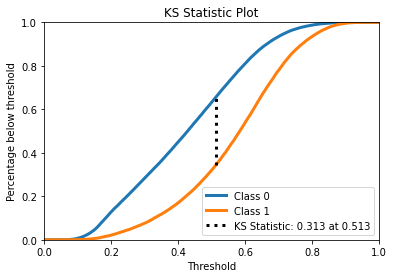


Accuracy:         0.6486
Recall:           0.6802
Precision:        0.4928
F1:               0.5715
AUROC:            0.7148
AUPR:             0.5546


In [103]:
y_pred = xgb_model.predict_proba(df_test_x)
y_pred_class = xgb_model.predict(df_test_x)
y_pred

print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(df_test_y.to_list(), y_pred_class, y_pred)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [134]:
params = {
    'colsample_bytree': 0.8762250265720735,
    'gamma': 0.4496789841331103,
    'learning_rate': 0.04884551054772856,
    'max_depth': 7,
    'n_estimators': 286,
    'subsample': 0.926731267021822
}

xgb_model_4 = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric="auc", early_stopping_rounds=10)

xgb_model_4.set_params(**params)

xgb_model_4.fit(x, y, verbose=2, eval_set=[(df_validX, df_validY)] )

[0]	validation_0-auc:0.66988
[1]	validation_0-auc:0.67754
[2]	validation_0-auc:0.68068
[3]	validation_0-auc:0.68524
[4]	validation_0-auc:0.68575
[5]	validation_0-auc:0.68554
[6]	validation_0-auc:0.68627
[7]	validation_0-auc:0.68697
[8]	validation_0-auc:0.68738
[9]	validation_0-auc:0.68832
[10]	validation_0-auc:0.69023
[11]	validation_0-auc:0.69114
[12]	validation_0-auc:0.69249
[13]	validation_0-auc:0.69274
[14]	validation_0-auc:0.69319
[15]	validation_0-auc:0.69400
[16]	validation_0-auc:0.69486
[17]	validation_0-auc:0.69531
[18]	validation_0-auc:0.69589
[19]	validation_0-auc:0.69651
[20]	validation_0-auc:0.69764
[21]	validation_0-auc:0.69821
[22]	validation_0-auc:0.69873
[23]	validation_0-auc:0.69911
[24]	validation_0-auc:0.69980
[25]	validation_0-auc:0.70033
[26]	validation_0-auc:0.70071
[27]	validation_0-auc:0.70109
[28]	validation_0-auc:0.70137
[29]	validation_0-auc:0.70170
[30]	validation_0-auc:0.70211
[31]	validation_0-auc:0.70240
[32]	validation_0-auc:0.70274
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8762250265720735, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.4496789841331103, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04884551054772856, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=286, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

best score: 0.717451051204767, best iteration: 249, best ntree limit 250


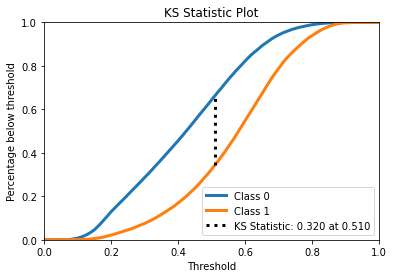


Accuracy:         0.6546
Recall:           0.6755
Precision:        0.4991
F1:               0.5741
AUROC:            0.7200
AUPR:             0.5624


In [135]:
y_pred = xgb_model_4.predict_proba(df_test_x)
y_pred_class = xgb_model_4.predict(df_test_x)
y_pred

print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model_4.best_score, xgb_model_4.best_iteration, xgb_model_4.best_ntree_limit))

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(df_test_y.to_list(), y_pred_class, y_pred)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [145]:
params = {
    'colsample_bytree': 0.8762250265720735,
    'gamma': 0.4596789841331103,
    'learning_rate': 0.4,
    'max_depth': 4,
    'n_estimators': 100,
    # 'subsample': 0.926731267021822
}

xgb_model_5 = xgb.XGBClassifier(objective='binary:logistic', random_state=17, eval_metric="map", early_stopping_rounds=20)

xgb_model_5.set_params(**params)

xgb_model_5.fit(x, y, verbose=2, eval_set=[(df_validX, df_validY)] )

[0]	validation_0-map:0.60410
[2]	validation_0-map:0.65729
[4]	validation_0-map:0.66938
[6]	validation_0-map:0.67469
[8]	validation_0-map:0.67850
[10]	validation_0-map:0.68151
[12]	validation_0-map:0.68338
[14]	validation_0-map:0.68533
[16]	validation_0-map:0.68711
[18]	validation_0-map:0.68770
[20]	validation_0-map:0.68854
[22]	validation_0-map:0.68968
[24]	validation_0-map:0.68998
[26]	validation_0-map:0.69095
[28]	validation_0-map:0.69109
[30]	validation_0-map:0.69136
[32]	validation_0-map:0.69165
[34]	validation_0-map:0.69188
[36]	validation_0-map:0.69219
[38]	validation_0-map:0.69233
[40]	validation_0-map:0.69246
[42]	validation_0-map:0.69260
[44]	validation_0-map:0.69270
[46]	validation_0-map:0.69258
[48]	validation_0-map:0.69267
[50]	validation_0-map:0.69296
[52]	validation_0-map:0.69307
[54]	validation_0-map:0.69308
[56]	validation_0-map:0.69324
[58]	validation_0-map:0.69347
[60]	validation_0-map:0.69359
[62]	validation_0-map:0.69376
[64]	validation_0-map:0.69366
[66]	validation

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8762250265720735, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='map', feature_types=None,
              gamma=0.4596789841331103, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=17, ...)

best score: 0.6874823716799127, best iteration: 163, best ntree limit 164


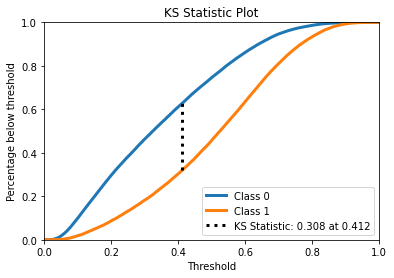


Accuracy:         0.6759
Recall:           0.5433
Precision:        0.5290
F1:               0.5360
AUROC:            0.7099
AUPR:             0.5482


In [143]:
y_pred = xgb_model_5.predict_proba(df_test_x)
y_pred_class = xgb_model_5.predict(df_test_x)
y_pred

print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model_5.best_score, xgb_model_5.best_iteration, xgb_model_5.best_ntree_limit))

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(df_test_y.to_list(), y_pred_class, y_pred)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
xgb_model_2 = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric="auc", early_stopping_rounds=10)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.01, 0.5), # default 0.1 
    "max_depth": randint(2, 8), # default 3
    "n_estimators": randint(100, 350), # default 100
    "subsample": uniform(0.6, 0.4)
}

tunning = RandomizedSearchCV(xgb_model_2, param_distributions=params, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

tunning.fit(x,y, verbose=1, eval_set=[(df_validX, df_validY)])

In [117]:
tunning

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=10,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BA82BBA6D0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BA82BB4880>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BA82BBA670>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BA8289C0A0>},
                   return_train_score=True, verbose=1)

In [119]:
import pandas as pd


df = pd.DataFrame(tunning.cv_results_)

In [124]:
# tunning.best_index_ --> 12
df.iloc[12].params

{'colsample_bytree': 0.8762250265720735,
 'gamma': 0.4496789841331103,
 'learning_rate': 0.04884551054772856,
 'max_depth': 7,
 'n_estimators': 286,
 'subsample': 0.926731267021822}

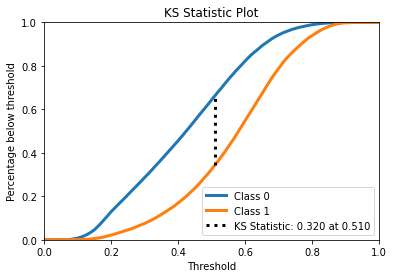


Accuracy:         0.6546
Recall:           0.6755
Precision:        0.4991
F1:               0.5741
AUROC:            0.7200
AUPR:             0.5624


In [128]:
y_pred = tunning.predict_proba(df_test_x)
y_pred_class = tunning.predict(df_test_x)
y_pred

# print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model_2.best_score, xgb_model_2.best_iteration, xgb_model_2.best_ntree_limit))

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(df_test_y.to_list(), y_pred_class, y_pred)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

array([0, 0, 1, ..., 0, 1, 0])

In [110]:
xgb_model_2.fit(x,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [114]:


def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")



In [116]:
report_best_scores(tunning.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.673 (std: 0.002)
Parameters: {'colsample_bytree': 0.8762250265720735, 'gamma': 0.4496789841331103, 'learning_rate': 0.04884551054772856, 'max_depth': 7, 'n_estimators': 286, 'subsample': 0.926731267021822}

Model with rank: 2
Mean validation score: 0.672 (std: 0.001)
Parameters: {'colsample_bytree': 0.8791844686827683, 'gamma': 0.176352635729233, 'learning_rate': 0.0756584004038006, 'max_depth': 7, 'n_estimators': 327, 'subsample': 0.7397620424856822}

Model with rank: 3
Mean validation score: 0.672 (std: 0.001)
Parameters: {'colsample_bytree': 0.9920667565036817, 'gamma': 0.22019881506580224, 'learning_rate': 0.07329329244461578, 'max_depth': 7, 'n_estimators': 293, 'subsample': 0.8524853057206281}



In [ ]:
xgb_model_3 = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric="auc", early_stopping_rounds=10)


params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.01, 0.5), # default 0.1 
    "max_depth": randint(2, 8), # default 3
    "n_estimators": randint(100, 350), # default 100
    "subsample": uniform(0.6, 0.4)
}

In [146]:
with open('./xgboost/feature_importances_hyperparams.pkl', 'wb') as f:
    pickle.dump(xgb_model_4.feature_importances_, f)